# <center> <h1> hyperparameter tuning Categorical Boosting </h1> </center>

In [1]:
# Import library
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
datos = pd.read_csv("heart.csv")
datos.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


## Duplicate values

In [3]:
datos[datos.duplicated()]
# drop duplicate values 
datos.drop_duplicates(keep='first',inplace=True)

## Scaling data

In [4]:
# copy the data 
df_copy = datos.copy()

from sklearn.preprocessing import MinMaxScaler
#Create objectscaler 
scaler = MinMaxScaler()
# Fit data
df_scaled = scaler.fit_transform(df_copy)
#convert array to data frame
df_scaled  = pd.DataFrame(df_scaled)
# Reset labels to data frame
df_scaled.columns = datos.columns
df_scaled.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0


# Configuracion de variables test y train

In [5]:
# define the variable 'x' and 'y'

X = df_scaled.drop('output', axis=1)
y = df_copy['output']

In [6]:
# Spliting data train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create models

## load models and metrics load models and metrics 

In [7]:
# import classification model
from catboost import CatBoostClassifier

# Metrics
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

##  hyperparameter tuning

Let's try to get the best parameter for our model 

In [8]:
from sklearn.model_selection import RandomizedSearchCV 

Cat_Boosting = CatBoostClassifier()

params = {
    'iterations': [10, 50, 100, 20, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 1, 10],
    'depth': [3, 5, 7, 9]
}

Cat_Boosting = GridSearchCV(CatBoostClassifier(verbose=0),params, cv = 5, n_jobs= -1)
Cat_Boosting.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002635768C670>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 7, 9],
                         'iterations': [10, 50, 100, 20, 300, 400, 500],
                         'learning_rate': [0.01, 0.1, 1, 10]})

In [9]:
# get beter params
print(f"{Cat_Boosting.best_params_}")
print(f"The best score: {Cat_Boosting.best_score_}")

{'depth': 3, 'iterations': 400, 'learning_rate': 0.01}
The best score: 0.855017006802721


# Importance of features in the classification model

In [10]:
# Adjust final model with best parameters
cat_model_final = CatBoostClassifier(iterations = Cat_Boosting.best_params_['iterations'],
                                      learning_rate = Cat_Boosting.best_params_['learning_rate'],
                                      depth = Cat_Boosting.best_params_['depth'], verbose = 0)

cat_model_final.fit(X_train, y_train)

In [11]:
# make model predictions about the test
prediccion_model = Cat_Boosting.predict(X_test)

# score accuracy predictions, the correct value is sent on the estimated
print(f'accuracy = {metrics.accuracy_score(y_test, prediccion_model)}')

accuracy = 0.7868852459016393


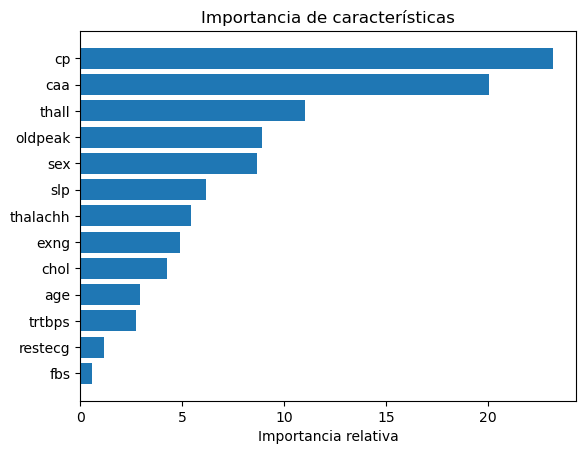

In [12]:
# Plot
feature_importance = cat_model_final.get_feature_importance()
feature_names = X_train.columns
sorted_idx = feature_importance.argsort()

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importancia relativa')
plt.title('Importancia de características')
plt.show()


The implemented model indicates that the most important aspects to highlight when assessing a patient are:<br>
-  cp “Chest_Pain_type” <br>
- caa  “number of major vessels” <br>
- thall thalassemia<br>
- old peak “ST depression induced by exercise relative to rest”<br>

And finally, the variables that provide the least information about this condition are:<br>
- fbs: “fasting blood sugar > 120 mg/dl”.<br>
- rest_ecg: resting electrocardiographic results

# Confusion Matrix

<Figure size 1100x1100 with 0 Axes>

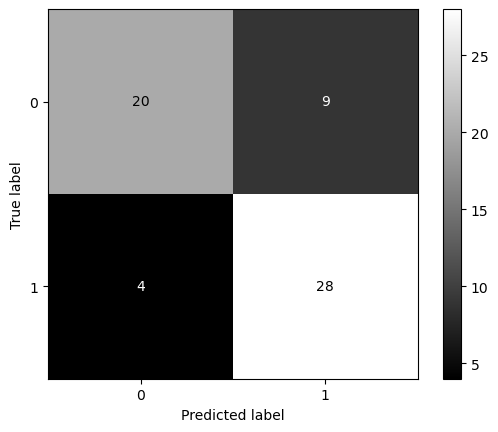

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig = plt.figure(figsize=(11,11))
cm = confusion_matrix(y_test, prediccion_model,  labels = Cat_Boosting.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Cat_Boosting.classes_)
disp.plot(cmap='gray')
plt.show()

# Make any predicct 

In [14]:
prediccion = Cat_Boosting.predict([26, 1, 0, 120, 200, 0, 1, 150, 1, 1.4, 2, 0, 1])
prediccion

0

In [15]:
# create data frame
labels = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh','exng', 'oldpeak', 'slp', 'caa', 'thall']
patient_1 =  [26, 1, 0, 120, 200, 0, 1, 150, 1, 1.4, 2, 0, 1]
patient_2 =  [80, 1, 2, 120, 260, 0, 1, 150, 1, 1.4, 2, 0, 1]
patient_3 =  [85, 0, 2, 150, 260, 0, 1, 150, 1, 1.4, 2, 0, 1]

In [16]:
# trasnform to dataframe
df = pd.DataFrame([patient_1, patient_2, patient_3], columns=labels, index=['patient 1', 'patient 2', 'patient 3'])
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
patient 1,26,1,0,120,200,0,1,150,1,1.4,2,0,1
patient 2,80,1,2,120,260,0,1,150,1,1.4,2,0,1
patient 3,85,0,2,150,260,0,1,150,1,1.4,2,0,1


In [17]:
# predit 
prediccion = Cat_Boosting.predict(df)

# convert to Data Frame
prediccion = pd.DataFrame(prediccion, columns = ['Estimate'], index= df.index)

# Show estimate
prediccion

,Estimate
patient 1,0
patient 2,1
patient 3,1


In [18]:
# save model
#import pickle

#pickle.dump(Cat_Boosting, open("Cat_Boosting.pkl", "wb"))